### **Data Access**

This notebook uses molecular dynamics trajectory and structure files stored on Google Drive.
The following cell mounts the Drive so that you can access the dataset.

- **alanine-dipeptide-nowater.pdb** : reference structure  
- **alanine-dipeptide-2-250ns-nowater.xtc** : MD trajectory (250 ns, no water, reference from mdshare)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Change working directory to where data is stored
%cd /content/drive/MyDrive/Resultats/Train_2

In [ ]:
!pip install mdtraj

### **Step I: Extract torsions from official trajectories**

Load .pdb and .xct, compute φ/ψ, save as .npy.

In [ ]:
import mdtraj as md
import numpy as np
import os

#Path
pdb_file = "alanine-dipeptide-nowater.pdb"
xtc_file = "alanine-dipeptide-2-250ns-nowater.xtc"
output_npy = "alanine_torsions_from_2_xtc.npy"
#Load
traj = md.load_xtc(xtc_file, top=pdb_file)
#Compute backbone torsion angles: φ and ψ
_, phi = md.compute_phi(traj)
_, psi = md.compute_psi(traj)
#Concatenate -> numpy file
torsions = np.concatenate([phi, psi], axis=1)
np.save(output_npy, torsions.astype(np.float32))

print(f"Torsion angle data saved to: {output_npy}")
print(f"Shape of torsion data: {torsions.shape}")

Torsion angle data saved to: alanine_torsions_from_2_xtc.npy
Shape of torsion data: (250000, 2)


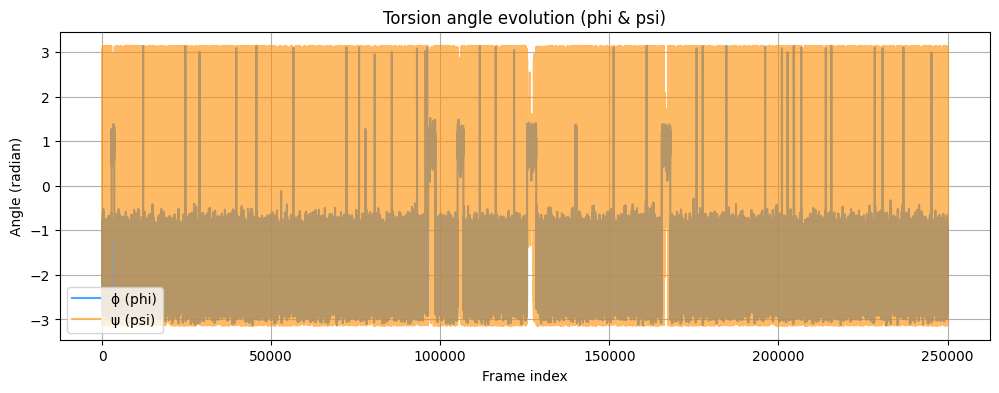

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

torsions = np.load("alanine_torsions_from_2_xtc.npy")

phi = torsions[:, 0]
psi = torsions[:, 1]

plt.figure(figsize=(12, 4))
plt.plot(phi, label="ϕ (phi)", color='dodgerblue', alpha=0.8)
plt.plot(psi, label="ψ (psi)", color='darkorange', alpha=0.6)
plt.title("Torsion angle evolution (phi & psi)")
plt.xlabel("Frame index")
plt.ylabel("Angle (radian)")
plt.legend()
plt.grid(True)
plt.show()

### **Step II: Diffusion Models Implementation**

Implement the classic diffusion model, but highlight two key mathematical tricks:

**1) Sinusoidal Time-Step Embedding**  
- **Goal**: Represent discrete timesteps as continuous vectors so that the model can *understand time flow*.  
- **Method**: Expand `t` onto sinusoidal basis functions with geometrically spaced frequencies:  

$$
e(t) = [\sin(t f_1), \cos(t f_1), \dots, \sin(t f_{d/2}), \cos(t f_{d/2})]
$$

where  
$$
f_j = 10000^{-j/(d/2-1)}
$$


**2) Cosine Noise Schedule (Nichol & Dhariwal, 2021)**  
- **Goal**: Control how fast the clean signal is drowned in noise during the forward diffusion process.  
- **Method**: Define cumulative noise decay with a cosine function:  

$$
\alpha_t = \frac{\cos^2\!\left(\frac{t/T+s}{1+s}\cdot \frac{\pi}{2}\right)}{\cos^2\!\left(\frac{s}{1+s}\cdot \frac{\pi}{2}\right)}, \quad s=0.008
$$  

The small offset $s$ prevents $\alpha_T$ from collapsing to zero, ensuring numerical stability.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math

# Dataset: torsional angles (phi and psi)
class TorsionDataset(Dataset):
    """Torsion-angle dataset for alanine dipeptide (or similar)
    Each simple is a pair of angles in radians with shape(2,)."""
    def __init__(self, torsion_data_path):
        self.torsions = np.load(torsion_data_path)  
        self.torsions = torch.FloatTensor(self.torsions)

    def __len__(self):
        return len(self.torsions)

    def __getitem__(self, idx):
        return self.torsions[idx]

# Sinusoidal time-step embedding
def get_timestep_embedding(timesteps, embedding_dim):
    """Standard sinusoidal embedding for diffusion time steps."""
    half_dim = embedding_dim // 2
    emb = math.log(10000) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, device=timesteps.device) * -emb)

    # [B,1] * [1,D/2] -> [B,D/2]
    emb = timesteps[:, None].float() * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    # Pad one dim if embedding_dim is odd
    if embedding_dim % 2 == 1:
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

# Score network on (φ, ψ)
class SimpleTorsionDiffusion(nn.Module):
    """small MLP that predicts noise on torsional angles phi and psi"""
    def __init__(self, hidden_dim=128, num_layers=4, time_embed_dim=64):
        super().__init__()
        self.hidden_dim = hidden_dim 
        self.time_embed_dim = time_embed_dim
        self.num_layers = num_layers 
        # Time embedding projection
        self.time_embed = nn.Sequential(
            nn.Linear(time_embed_dim, hidden_dim),
            nn.SiLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )
        # Input branch
        self.input_layer = nn.Linear(2, hidden_dim)
        self.input_activation = nn.SiLU()
        # Hidden blocks: (Linear + SiLU) x (num_layers - 2)
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_layers - 2):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))
            self.hidden_layers.append(nn.SiLU())
        # Output: predict noise on two angles
        self.output_layer = nn.Linear(hidden_dim, 2)


    def forward(self, x, t):
        # Time embedding -> hidden_dim
        t_emb = get_timestep_embedding(t, self.time_embed_dim).to(x.device).to(x.dtype)
        t_emb = self.time_embed(t_emb) # [B, H]
        # Input projection
        h = self.input_layer(x) 
        h = self.input_activation(h) 
        # Inject time embedding before each linear layer (FiLM-style addition)
        for i in range(0, len(self.hidden_layers), 2): 
            linear_layer = self.hidden_layers[i]
            activation = self.hidden_layers[i+1]
            h = h + t_emb # Add time embedding before the linear layer
            h = linear_layer(h)
            h = activation(h)
        # Predict noise εθ
        h = self.output_layer(h)
        return h

# DDPM on torsional angles
class TorsionDDPM:
    """DDPM pipeline operating directly in torsion space."""
    def __init__(self, model, device='cuda', num_timesteps=1000, beta_schedule='linear'):
        self.model = model.to(device)
        self.device = device
        self.num_timesteps = num_timesteps
        # Set noise schedule β_t
        self.setup_noise_schedule(beta_schedule)

    def setup_noise_schedule(self, schedule_type='linear'):
        """Create β_t and derived α products."""
        if schedule_type == 'linear':
            self.beta = torch.linspace(0.0001, 0.02, self.num_timesteps).to(self.device).to(torch.float32) # Ensure float32
        elif schedule_type == 'cosine':
            # Cosine schedule (Nichol & Dhariwal)
            s = 0.008
            steps = self.num_timesteps + 1
            x = torch.linspace(0, self.num_timesteps, steps).to(self.device).to(torch.float32) # Ensure float32
            alphas_cumprod = torch.cos(((x / self.num_timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
            alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
            betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
            self.beta = torch.clip(betas, 0, 0.999).to(self.device).to(torch.float32) # Ensure float32

        self.alpha = 1.0 - self.beta
        self.alpha_cumprod = torch.cumprod(self.alpha, dim=0)
        self.alpha_cumprod_prev = torch.cat([torch.ones(1).to(self.device).to(torch.float32), self.alpha_cumprod[:-1]]) # Ensure float32

        # Useful terms in Diffusion Model
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1.0 - self.alpha_cumprod)
        self.sqrt_recip_alpha_cumprod = torch.sqrt(1.0 / self.alpha_cumprod)
        self.sqrt_recipm1_alpha_cumprod = torch.sqrt(1.0 / self.alpha_cumprod - 1)

    def q_sample(self, x_start, t, noise=None):
        """Forward diffusion q(x_t | x_0): add noise at time t."""
        if noise is None:
            noise = torch.randn_like(x_start)

        # Ensure indexing uses correct data type
        sqrt_alpha_cumprod_t = self.sqrt_alpha_cumprod[t]
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod[t]

        return (sqrt_alpha_cumprod_t.view(-1, 1) * x_start +
                sqrt_one_minus_alpha_cumprod_t.view(-1, 1) * noise), noise

    def predict_start_from_noise(self, x_t, t, noise_pred):
        """Reconstruct x_0 from x_t and predicted noise."""
        return (self.sqrt_recip_alpha_cumprod[t].view(-1, 1) * x_t -
                self.sqrt_recipm1_alpha_cumprod[t].view(-1, 1) * noise_pred)

    def q_posterior(self, x_start, x_t, t):
        """Posterior q(x_{t-1} | x_t, x_0): mean/variance/log-variance."""
        beta_t = self.beta[t]
        alpha_cumprod_t = self.alpha_cumprod[t]
        alpha_cumprod_prev_t = self.alpha_cumprod_prev[t]
        alpha_t = self.alpha[t]

        posterior_variance = beta_t * (1.0 - alpha_cumprod_prev_t) / (1.0 - alpha_cumprod_t)
        posterior_log_variance_clipped = torch.log(torch.maximum(posterior_variance, torch.tensor(1e-20).to(self.device))) # Ensure tensor is on device

        posterior_mean_coef1 = beta_t * torch.sqrt(alpha_cumprod_prev_t) / (1.0 - alpha_cumprod_t)
        posterior_mean_coef2 = (1.0 - alpha_cumprod_prev_t) * torch.sqrt(alpha_t) / (1.0 - alpha_cumprod_t)

        posterior_mean = (posterior_mean_coef1.view(-1, 1) * x_start +
                         posterior_mean_coef2.view(-1, 1) * x_t)

        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, x_t, t):
        """Model mean/variance for the reverse step; enforce periodicity."""
        noise_pred = self.model(x_t, t)
        x_start_pred = self.predict_start_from_noise(x_t, t, noise_pred)
        x_start_pred = torch.remainder(x_start_pred + math.pi, 2 * math.pi) - math.pi # May angles back to (-π, π]
        model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start_pred, x_t, t)
        return model_mean, posterior_variance, posterior_log_variance, x_start_pred

    def p_sample(self, x_t, t):
        """One reverse-diffusion step: x_{t-1} ~ pθ(x_{t-1} | x_t)."""
        model_mean, _, model_log_variance, _ = self.p_mean_variance(x_t, t)
        noise = torch.randn_like(x_t)
        nonzero_mask = (t != 0).float().view(-1, 1) # No noise when t == 0
        model_std = torch.exp(0.5 * model_log_variance).view(-1, 1)
        return model_mean + nonzero_mask * model_std * noise

    def train_step(self, batch):
        """One training step: sample t, add noise, predict noise, MSE loss."""
        x_0 = batch.to(self.device)
        batch_size = x_0.shape[0]
        # Uniformly sample time steps per exemple
        t = torch.randint(0, self.num_timesteps, (batch_size,), device=self.device, dtype=torch.long)
        # Forward diffusion
        x_t, noise = self.q_sample(x_0, t)
        # Predict noise εθ
        noise_pred = self.model(x_t, t)
        # DDPM objective
        loss = nn.MSELoss()(noise_pred, noise)
        return loss

    def train(self, dataloader, epochs=100, lr=1e-3):
        """Training loop with AdamW, cosine LR, and grad clipping."""
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

        self.model.train()
        for epoch in range(epochs):
            total_loss = 0
            for batch in dataloader:
                optimizer.zero_grad()

                loss = self.train_step(batch)
                loss.backward()

                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                total_loss += loss.item()

            scheduler.step()
            avg_loss = total_loss / len(dataloader)
            current_lr = scheduler.get_last_lr()[0]

            if (epoch + 1) % 10 == 0:
                print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.6f}, LR: {current_lr:.6f}")

    def sample(self, num_samples=1000, return_trajectory=False):
        """Generate new torsions from the trained model."""
        self.model.eval()

        with torch.no_grad():
            x = torch.randn(num_samples, 2, device=self.device) # x_T ~ N(0, I)
            trajectory = [x.cpu().numpy()] if return_trajectory else None
            # Reverse process: T → 0
            for t in reversed(range(self.num_timesteps)):
                t_tensor = torch.full((num_samples,), t, device=self.device, dtype=torch.long)
                x = self.p_sample(x, t_tensor)
                if return_trajectory and t % 100 == 0:
                    trajectory.append(x.cpu().numpy())
            # Wrap to (-π, π]
            x = torch.remainder(x + math.pi, 2 * math.pi) - math.pi

        if return_trajectory:
            return x.cpu().numpy(), trajectory
        return x.cpu().numpy()

    def interpolate(self, x1, x2, num_steps=10):
        """Spherical-like interpolation via noisy midpoint then reverse."""
        self.model.eval()

        with torch.no_grad():
            x1 = torch.tensor(x1, device=self.device, dtype=torch.float32).unsqueeze(0)
            x2 = torch.tensor(x2, device=self.device, dtype=torch.float32).unsqueeze(0)

             # Add noise at mid-time
            t = torch.full((1,), self.num_timesteps // 2, device=self.device, dtype=torch.long)
            x1_noisy, _ = self.q_sample(x1, t)
            x2_noisy, _ = self.q_sample(x2, t)

            # Linear mix in noisy space, then reverse to t=0
            interpolated = []
            for i in range(num_steps):
                alpha = i / (num_steps - 1)
                x_interp = (1.0 - float(alpha)) * x1_noisy + float(alpha) * x2_noisy
                for t_step in reversed(range(self.num_timesteps // 2)):
                    t_tensor = torch.full((1,), t_step, device=self.device, dtype=torch.long)
                    x_interp = self.p_sample(x_interp, t_tensor)

                interpolated.append(x_interp.cpu().numpy()[0])

        return np.array(interpolated)


def main():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    batch_size = 256
    epochs = 200
    lr = 1e-3
    torsion_data_path = "alanine_torsions_from_2_xtc.npy"

    dataset = TorsionDataset(torsion_data_path)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

    print(f"Dataset size: {len(dataset)}")
    print(f"Data shape: {dataset.torsions.shape}")

    model = SimpleTorsionDiffusion(hidden_dim=256, num_layers=6, time_embed_dim=128)
    ddpm = TorsionDDPM(model, device=device, num_timesteps=1000, beta_schedule='cosine')

    print(f"Model parameters: {sum(p.numel() for p in model.parameters())}")
    print(f"Training on device: {device}")

    ddpm.train(dataloader, epochs=epochs, lr=lr)

    torch.save({
        'model_state_dict': model.state_dict(),
        'num_timesteps': ddpm.num_timesteps,
        'beta_schedule': 'cosine'
    }, 'torsion_ddpm_model.pth')
    print("Model saved!")

    print("Generating samples...")
    samples = ddpm.sample(num_samples=100)
    samples_deg = np.rad2deg(samples)

    print(f"Generated samples shape: {samples.shape}")
    print(f"Sample statistics (degrees):")
    print(f"Phi - Mean: {samples_deg[:, 0].mean():.2f}, Std: {samples_deg[:, 0].std():.2f}")
    print(f"Psi - Mean: {samples_deg[:, 1].mean():.2f}, Std: {samples_deg[:, 1].std():.2f}")

    np.save('generated_torsion_samples_ddpm_2.npy', samples)
    print("Generated samples saved!")

    print("Testing interpolation...")
    x1 = np.array([-2.0, -1.0])  
    x2 = np.array([1.0, 2.0])    
    interpolated = ddpm.interpolate(x1, x2, num_steps=10)
    print(f"Interpolation shape: {interpolated.shape}")

    np.save('interpolated_torsions_2.npy', interpolated)
    print("Interpolation results saved!")

if __name__ == "__main__":
    main()

Dataset size: 250000
Data shape: torch.Size([250000, 2])
Model parameters: 363266
Training on device: cuda
Epoch 10/200, Loss: 0.403421, LR: 0.000994
Epoch 20/200, Loss: 0.403199, LR: 0.000976
Epoch 30/200, Loss: 0.399933, LR: 0.000946
Epoch 40/200, Loss: 0.399742, LR: 0.000905
Epoch 50/200, Loss: 0.398497, LR: 0.000854
Epoch 60/200, Loss: 0.397768, LR: 0.000794
Epoch 70/200, Loss: 0.398571, LR: 0.000727
Epoch 80/200, Loss: 0.395489, LR: 0.000655
Epoch 90/200, Loss: 0.397540, LR: 0.000578
Epoch 100/200, Loss: 0.395522, LR: 0.000500
Epoch 110/200, Loss: 0.396387, LR: 0.000422
Epoch 120/200, Loss: 0.397626, LR: 0.000345
Epoch 130/200, Loss: 0.396366, LR: 0.000273
Epoch 140/200, Loss: 0.392840, LR: 0.000206
Epoch 150/200, Loss: 0.397042, LR: 0.000146
Epoch 160/200, Loss: 0.393665, LR: 0.000095
Epoch 170/200, Loss: 0.395082, LR: 0.000054
Epoch 180/200, Loss: 0.394291, LR: 0.000024
Epoch 190/200, Loss: 0.396259, LR: 0.000006
Epoch 200/200, Loss: 0.394213, LR: 0.000000
Model saved!
Generatin

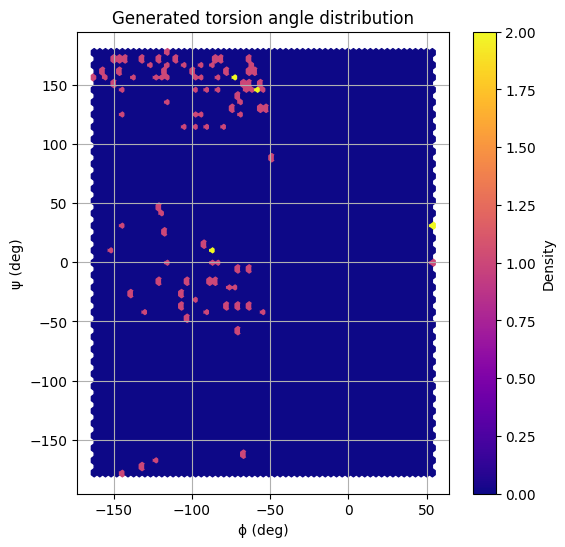

In [ ]:
# Visualisation to check Torsion angle distribution
import numpy as np
import matplotlib.pyplot as plt

samples = np.load("generated_torsion_samples_ddpm_2.npy")
phi = np.rad2deg(samples[:, 0])
psi = np.rad2deg(samples[:, 1])

plt.figure(figsize=(6,6))
plt.hexbin(phi, psi, gridsize=60, cmap="plasma")
plt.xlabel("ϕ (deg)")
plt.ylabel("ψ (deg)")
plt.title("Generated torsion angle distribution")
plt.colorbar(label="Density")
plt.grid(True)
plt.show()

# TODO: Future work, it should compare with real pdb torsion (Ramachandran)

In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()

!mamba install -c conda-forge openmmforcefields -y

In [ ]:
!mamba install -c conda-forge openmm -y
!mamba install -c conda-forge rdkit -y

### **Step III: Boltzmann adjustment**
After generating raw torsion angle samples and building 3D conformations, we apply a **Boltzmann reweighting** using MMFF94 energies.  
- Compute MMFF94 energy for each conformer  
- Compute Boltzmann weights at 298 K (kT ≈ 0.593 kcal/mol)  
- Resample conformations (or directly use weighted histograms) according to these probabilities  

This step enforces **physical plausibility** by suppressing high-energy conformations and enhancing low-energy basins, yielding a torsion angle distribution closer to reality.

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from typing import List, Tuple

def load_generated_samples(torsion_file: str, mol_smiles: str) -> Tuple[np.ndarray, Chem.Mol]:
    torsions = np.load(torsion_file)
    mol = Chem.MolFromSmiles(mol_smiles)
    mol = Chem.AddHs(mol)
    return torsions, mol

def get_rotatable_bonds(mol: Chem.Mol) -> List[Tuple[int, int, int, int]]:
    rotatable_bonds = []
    for bond in mol.GetBonds():
        atom1 = bond.GetBeginAtom()
        atom2 = bond.GetEndAtom()
        if atom1.GetDegree() == 1 or atom2.GetDegree() == 1:
            continue
        if bond.GetIsAromatic():
            continue
        neighbors1 = [n for n in atom1.GetNeighbors() if n.GetIdx() != atom2.GetIdx()]
        neighbors2 = [n for n in atom2.GetNeighbors() if n.GetIdx() != atom1.GetIdx()]
        if neighbors1 and neighbors2:
            rotatable_bonds.append((
                neighbors1[0].GetIdx(),
                atom1.GetIdx(),
                atom2.GetIdx(),
                neighbors2[0].GetIdx()
            ))
    return rotatable_bonds

def set_torsion_angle(mol: Chem.Mol, bond_indices: Tuple[int, int, int, int], angle: float):
    conf = mol.GetConformer()
    angle_deg = float(np.degrees(angle))
    AllChem.SetDihedralDeg(
        conf,
        int(bond_indices[0]),
        int(bond_indices[1]),
        int(bond_indices[2]),
        int(bond_indices[3]),
        angle_deg
    )

def generate_3d_conformations(mol: Chem.Mol, torsions: np.ndarray) -> List[Chem.Mol]:
    conformations = []
    rotatable_bonds = get_rotatable_bonds(mol)
    for torsion_set in torsions:
        conf_mol = Chem.Mol(mol)
        AllChem.EmbedMolecule(conf_mol, randomSeed=42)
        for bond_idx, torsion_angle in zip(rotatable_bonds, torsion_set):
            set_torsion_angle(conf_mol, bond_idx, torsion_angle)
        conformations.append(conf_mol)
    return conformations

In [ ]:
torsions, mol = load_generated_samples("generated_torsion_samples_ddpm_2.npy", "CC(=O)NC(C)C(=O)NC")
conformations = generate_3d_conformations(mol, torsions)
print(f"Generate {len(conformations)} conformations")

Generate 100 conformations


In [ ]:
from rdkit.Chem import AllChem
import numpy as np

def get_mmff_energy(mol):
    try:
        mp = AllChem.MMFFGetMoleculeProperties(mol, mmffVariant='MMFF94')
        ff = AllChem.MMFFGetMoleculeForceField(mol, mp)
        energy = ff.CalcEnergy()
        return energy
    except Exception as e:
        print("MMFF energy calculation failed:", e)
        return None

#conformations: List[Chem.Mol]
energies = []
for mol in conformations:
    e = get_mmff_energy(mol)
    energies.append(e)
    print(f"  MMFF94 Energy: {e:.2f} kcal/mol\n")

energies = np.array(energies)
valid = np.isfinite(energies)
energies = energies[valid]
conformations = [c for c, v in zip(conformations, valid) if v]

# Boltzmann reweighting（Use 298K kT=0.593 kcal/mol）
kT = 0.593  # kcal/mol
boltzmann_weights = np.exp(-energies / kT)
boltzmann_weights /= boltzmann_weights.sum()

n_resampled = 100
indices = np.random.choice(len(conformations), size=n_resampled, p=boltzmann_weights, replace=True)
resampled_conformations = [conformations[i] for i in indices]

  MMFF94 Energy: 36.32 kcal/mol

  MMFF94 Energy: 23.43 kcal/mol

  MMFF94 Energy: 30.01 kcal/mol

  MMFF94 Energy: 25.65 kcal/mol

  MMFF94 Energy: 39.88 kcal/mol

  MMFF94 Energy: 24.18 kcal/mol

  MMFF94 Energy: 25.85 kcal/mol

  MMFF94 Energy: 27.57 kcal/mol

  MMFF94 Energy: 26.95 kcal/mol

  MMFF94 Energy: 39.53 kcal/mol

  MMFF94 Energy: 28.86 kcal/mol

  MMFF94 Energy: 22.44 kcal/mol

  MMFF94 Energy: 35.99 kcal/mol

  MMFF94 Energy: 28.64 kcal/mol

  MMFF94 Energy: 28.89 kcal/mol

  MMFF94 Energy: 24.57 kcal/mol

  MMFF94 Energy: 25.72 kcal/mol

  MMFF94 Energy: 36.51 kcal/mol

  MMFF94 Energy: 24.54 kcal/mol

  MMFF94 Energy: 27.44 kcal/mol

  MMFF94 Energy: 25.03 kcal/mol

  MMFF94 Energy: 30.92 kcal/mol

  MMFF94 Energy: 23.34 kcal/mol

  MMFF94 Energy: 29.05 kcal/mol

  MMFF94 Energy: 25.45 kcal/mol

  MMFF94 Energy: 24.07 kcal/mol

  MMFF94 Energy: 24.32 kcal/mol

  MMFF94 Energy: 28.91 kcal/mol

  MMFF94 Energy: 31.70 kcal/mol

  MMFF94 Energy: 24.68 kcal/mol

  MMFF94 E

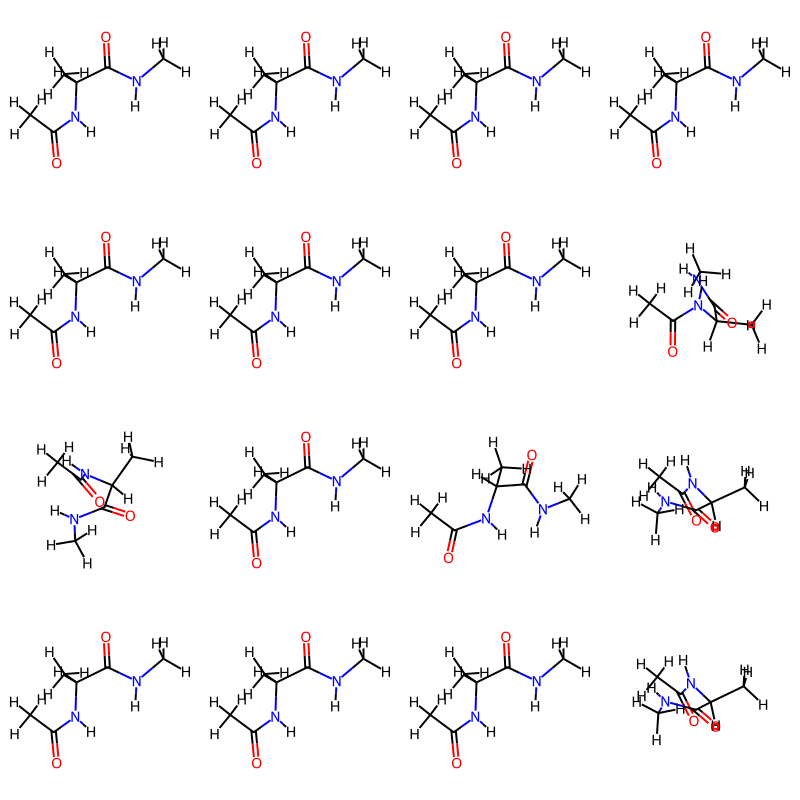

In [ ]:
from rdkit.Chem import Draw

Draw.MolsToGridImage(resampled_conformations[:16], molsPerRow=4, subImgSize=(200,200))

In [ ]:
# Save conformations obtained by third step
for i, mol in enumerate(resampled_conformations):
    Chem.MolToPDBFile(mol, f"resampled_2_conf_{i}.pdb")

### **Step IV: MD trajectory initialization**
After Boltzmann adjustment, the reweighted conformations are exported as PDB files and used as starting structures for Molecular Dynamics (MD) simulations.  

- Export reweighted conformations into `.pdb` format  
- Fix/parameterize molecules with **PDBFixer**, **ParmEd**, and **OpenFF Toolkit**  
- Generate force field parameters (GAFF/OpenFF)  
- Initialize and run simulations using **OpenMM**  

This step connects the generative torsion angle model to actual physics-based simulations, enabling validation and further sampling of conformational space.

**Difference from a "normal" protein MD setup:**
- Instead of starting from an experimental PDB, here we **simulate generated conformers**.  
- Force field registration (`GAFFTemplateGenerator`) is required because these molecules are not standard residues.  
- The goal is not to reproduce crystallographic coordinates, but to validate whether **generated torsion samples lead to stable conformations** under physical simulation.

In [ ]:
from pdbfixer import PDBFixer

import parmed as pmd
from openmm.app import *
from openmm import *
from openmm.unit import *
from sys import stdout
import numpy as np

In [ ]:
from openff.toolkit.topology import Molecule

off_mols = [Molecule.from_rdkit(m, allow_undefined_stereo=True) for m in resampled_conformations]

In [ ]:
from openmmforcefields.generators import GAFFTemplateGenerator
from openmm.app import PDBFile, ForceField, Modeller
from openmm import unit, Vec3

for i in range(100):
    pdb_in = f"resampled_2_conf_{i}.pdb"
    pdb = PDBFile(pdb_in)
    off_mol = off_mols[i]
    forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
    gaff = GAFFTemplateGenerator(molecules=[off_mol])
    forcefield.registerTemplateGenerator(gaff.generator)
    # add water
    modeller = Modeller(pdb.topology, pdb.positions)
    modeller.addSolvent(forcefield, model='tip3p', boxSize=Vec3(6,6,6)*unit.nanometer)
    system = forcefield.createSystem(
        modeller.topology,
        nonbondedMethod=PME,
        nonbondedCutoff=1.0*nanometer,
        constraints=HBonds
        )
    # save pdb after adding water
    solvated_pdb = f"resampled_2_conf_{i}_solvated.pdb"
    with open(solvated_pdb, 'w') as f:
        PDBFile.writeFile(modeller.topology, modeller.positions, f)

In [ ]:
import mdtraj as md

target_atoms = 21331
for i in range(100):
    solvated_pdb = f"resampled_2_conf_{i}_solvated.pdb"
    trimmed_pdb = f"trimmed_2_conf_{i}_solvated.pdb"
    traj = md.load_pdb(solvated_pdb)
    if traj.n_atoms >= target_atoms:
        atom_indices = list(range(target_atoms))
        trimmed = traj.atom_slice(atom_indices)
        trimmed.save_pdb(trimmed_pdb)
        print(f"{solvated_pdb} 修剪为 {trimmed_pdb}，共 {target_atoms} atoms")
    else:
        print(f"{solvated_pdb} atoms insuffisantes! sautew!")

resampled_2_conf_0_solvated.pdb 修剪为 trimmed_2_conf_0_solvated.pdb，共 21331 atoms
resampled_2_conf_1_solvated.pdb 修剪为 trimmed_2_conf_1_solvated.pdb，共 21331 atoms
resampled_2_conf_2_solvated.pdb 修剪为 trimmed_2_conf_2_solvated.pdb，共 21331 atoms
resampled_2_conf_3_solvated.pdb 修剪为 trimmed_2_conf_3_solvated.pdb，共 21331 atoms
resampled_2_conf_4_solvated.pdb 修剪为 trimmed_2_conf_4_solvated.pdb，共 21331 atoms
resampled_2_conf_5_solvated.pdb 修剪为 trimmed_2_conf_5_solvated.pdb，共 21331 atoms
resampled_2_conf_6_solvated.pdb 修剪为 trimmed_2_conf_6_solvated.pdb，共 21331 atoms
resampled_2_conf_7_solvated.pdb 修剪为 trimmed_2_conf_7_solvated.pdb，共 21331 atoms
resampled_2_conf_8_solvated.pdb 修剪为 trimmed_2_conf_8_solvated.pdb，共 21331 atoms
resampled_2_conf_9_solvated.pdb 修剪为 trimmed_2_conf_9_solvated.pdb，共 21331 atoms
resampled_2_conf_10_solvated.pdb 修剪为 trimmed_2_conf_10_solvated.pdb，共 21331 atoms
resampled_2_conf_11_solvated.pdb atoms insuffisantes! sautew!
resampled_2_conf_12_solvated.pdb 修剪为 trimmed_2_conf_12_s

In [ ]:
import glob
import numpy as np
from openmmforcefields.generators import GAFFTemplateGenerator
from openmm.app import PDBFile, ForceField, Simulation
import openmm.app as app
from openmm import LangevinMiddleIntegrator, Platform, unit
import os

temperature = 300 * kelvin
pdb_files = sorted(glob.glob("trimmed_2_conf_*_solvated.pdb"))

positions_all = []
forces_all = []
energies_all = []

try:
    platform = Platform.getPlatformByName('CUDA')
    properties = {'CudaPrecision': 'mixed'}
except Exception:
    platform = Platform.getPlatformByName('CPU')
    properties = {}

for pdb_file in pdb_files:
    print(f"Running: {pdb_file}")
    pdb = PDBFile(pdb_file)
    forcefield = ForceField('amber14-all.xml', 'amber14/tip3pfb.xml')
    # The variable `off_mol` was defined in a previous cell and is assumed to still be available.
    # If not, you might need to load or create it again before this loop.
    gaff = GAFFTemplateGenerator(molecules=[off_mol])
    forcefield.registerTemplateGenerator(gaff.generator)
    system = forcefield.createSystem(
            pdb.topology,
            nonbondedMethod=app.PME,
            nonbondedCutoff=1.0*unit.nanometer, # Access nanometer through unit
            constraints=app.HBonds,
        )
    integrator = LangevinMiddleIntegrator(temperature, 1/unit.picosecond, 0.002*unit.picosecond) # Access picosecond through unit
    simulation = Simulation(pdb.topology, system, integrator, platform, properties)
    simulation.context.setPositions(pdb.positions)
    simulation.minimizeEnergy()
    simulation.context.setVelocitiesToTemperature(temperature)

    total_steps = 10000
    output_frequency = 1000

    pos_traj = []
    force_traj = []
    energy_traj = []

    for step in range(total_steps):
        simulation.step(1)
        if step % output_frequency == 0:
            state = simulation.context.getState(getPositions=True, getForces=True, getEnergy=True)
            pos_traj.append(state.getPositions(asNumpy=True)._value)
            force_traj.append(state.getForces(asNumpy=True)._value)
            energy_traj.append(state.getPotentialEnergy().value_in_unit(unit.kilojoule_per_mole)) # Access kilojoule_per_mole through unit
        if step % 1000 == 0:
            print(f"traj {i}: Step {step} completed")

    positions_all.append(np.array(pos_traj))
    forces_all.append(np.array(force_traj))
    energies_all.append(np.array(energy_traj))

outdict = {}
for i in range(len(pdb_files)): # Iterate through the collected trajectories
    outdict[f'pos_{i}'] = positions_all[i]   # (frames, atoms, 3)
    outdict[f'force_{i}'] = forces_all[i]
    outdict[f'energy_{i}'] = energies_all[i]


np.savez("SMA_parallel_traj_ensemble_final_2.npz", **outdict)
print("全部轨迹采样完成，已保存为 SMA_parallel_traj_ensemble.npz")

Running: trimmed_2_conf_0_solvated.pdb
traj 99: Step 0 completed
traj 99: Step 1000 completed
traj 99: Step 2000 completed
traj 99: Step 3000 completed
traj 99: Step 4000 completed
traj 99: Step 5000 completed
traj 99: Step 6000 completed
traj 99: Step 7000 completed
traj 99: Step 8000 completed
traj 99: Step 9000 completed
Running: trimmed_2_conf_10_solvated.pdb
traj 99: Step 0 completed
traj 99: Step 1000 completed
traj 99: Step 2000 completed
traj 99: Step 3000 completed
traj 99: Step 4000 completed
traj 99: Step 5000 completed
traj 99: Step 6000 completed
traj 99: Step 7000 completed
traj 99: Step 8000 completed
traj 99: Step 9000 completed
Running: trimmed_2_conf_12_solvated.pdb
traj 99: Step 0 completed
traj 99: Step 1000 completed
traj 99: Step 2000 completed
traj 99: Step 3000 completed
traj 99: Step 4000 completed
traj 99: Step 5000 completed
traj 99: Step 6000 completed
traj 99: Step 7000 completed
traj 99: Step 8000 completed
traj 99: Step 9000 completed
Running: trimmed_2_c

In [ ]:
import numpy as np
data = np.load("SMA_parallel_traj_ensemble_final_2.npz")
for k in data.files:
    print(k, data[k].shape)

pos_0 (10, 21331, 3)
force_0 (10, 21331, 3)
energy_0 (10,)
pos_1 (10, 21331, 3)
force_1 (10, 21331, 3)
energy_1 (10,)
pos_2 (10, 21331, 3)
force_2 (10, 21331, 3)
energy_2 (10,)
pos_3 (10, 21331, 3)
force_3 (10, 21331, 3)
energy_3 (10,)
pos_4 (10, 21331, 3)
force_4 (10, 21331, 3)
energy_4 (10,)
pos_5 (10, 21331, 3)
force_5 (10, 21331, 3)
energy_5 (10,)
pos_6 (10, 21331, 3)
force_6 (10, 21331, 3)
energy_6 (10,)
pos_7 (10, 21331, 3)
force_7 (10, 21331, 3)
energy_7 (10,)
pos_8 (10, 21331, 3)
force_8 (10, 21331, 3)
energy_8 (10,)
pos_9 (10, 21331, 3)
force_9 (10, 21331, 3)
energy_9 (10,)
pos_10 (10, 21331, 3)
force_10 (10, 21331, 3)
energy_10 (10,)
pos_11 (10, 21331, 3)
force_11 (10, 21331, 3)
energy_11 (10,)
pos_12 (10, 21331, 3)
force_12 (10, 21331, 3)
energy_12 (10,)
pos_13 (10, 21331, 3)
force_13 (10, 21331, 3)
energy_13 (10,)
pos_14 (10, 21331, 3)
force_14 (10, 21331, 3)
energy_14 (10,)
pos_15 (10, 21331, 3)
force_15 (10, 21331, 3)
energy_15 (10,)
pos_16 (10, 21331, 3)
force_16 (10, 21